In [13]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [14]:
env = BlackjackEnv()

In [16]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [17]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        best_action_idx = np.argmax(Q[observation])
        A = np.zeros(len(Q[observation]))
        A[best_action_idx] = 1.0
        return A

        # Implement this!
    return policy_fn

In [26]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    for e in range(1, num_episodes+1):
        
        if e % 10000 == 0:
            print("\rEpisode {}/{}.".format(e, num_episodes), end="")
            sys.stdout.flush()
        # behavior policy episode
        state = env.reset()
        episode = []
        while True:
            probs = behavior_policy(state)
            action = np.random.choice(np.arange(env.action_space.n), p = probs)
            next_state, reward, done, _  = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        G = 0.0
        W = 1.0
        for t in range(len(episode)-1, -1, -1):
            state, action, reward = episode[t]
            G = G * discount_factor + reward
            # W always grows more than 1 and C is Cumulative W so its always bigger
            # W is 1 at the end of episodes and is amplified the further towards the 
            # beginning you go. So (W/C) the updated proportion, is always decreasing nonmonitonicly
            C[state][action] += W
            # The weighted average of rewards, equates to: (1- W/C)*Q + W/C*G
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            # If the action taken by the behavior policy at the state is not the action 
            # taken by the target policy at the state the probability will be 0 and we can break
            
            # This means that only the consecutive steps from the end back which overlap in both 
            # behavior and target policies, will be used to update. In the algorithm this is setting W = 0 when target and behavior dont overlap
            if action !=  np.argmax(target_policy(state)):
                break
            # Else: W always grows, target(1)/behavioral(<1) always greater than 1
            # In this example of behavioral policy, W * 1/(1/nA) --> W * nA !!!
            W = W * target_policy(state)[action]/behavior_policy(state)[action]

        
    return Q, target_policy

In [27]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

Episode 500000/500000.

NameError: name 'probs' is not defined

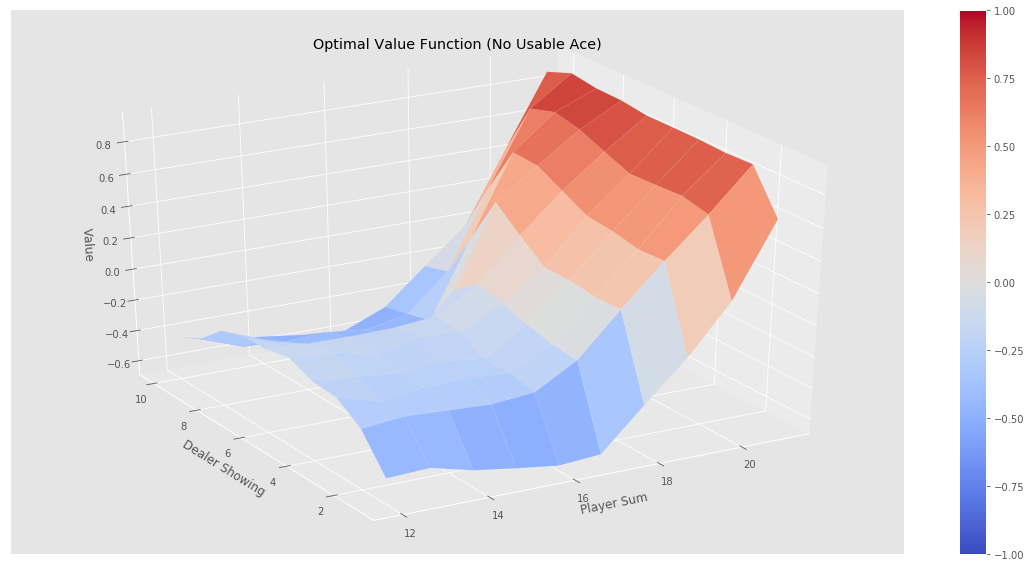

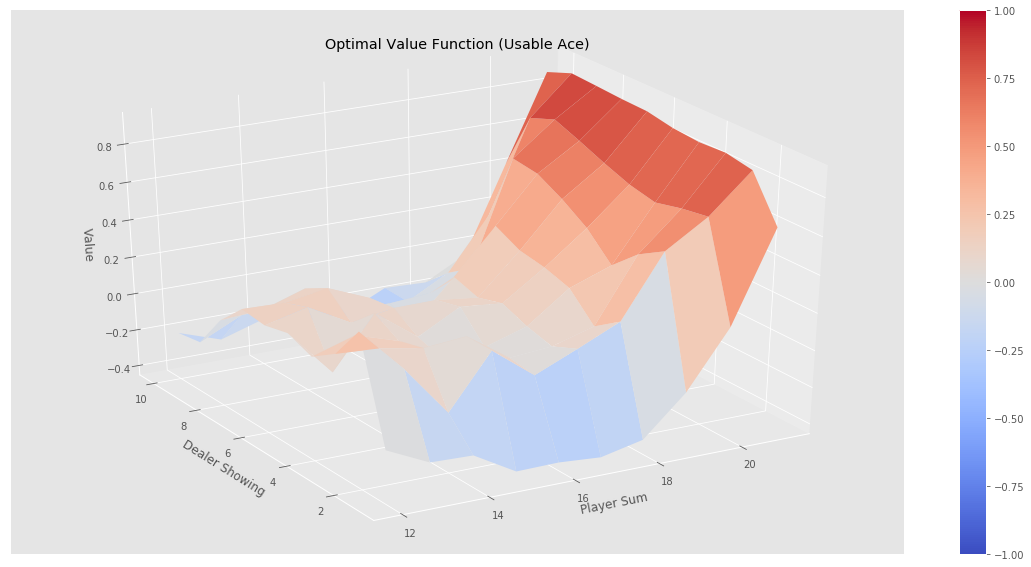

In [28]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")